In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import torch
import json
import plotly.express as px
from transformer_lens import utils
from datasets import load_dataset
from typing import Dict
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from functools import partial

from huggingface_hub import hf_hub_download



from sae_training.utils import LMSparseAutoencoderSessionloader
from sae_analysis.visualizer.data_fns import get_feature_data, FeatureData

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_grad_enabled(False)

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Start by downloading them from huggingface

REPO_ID = "jbloom/GPT2-Small-SAEs"


layer = 6  # any layer from 0 - 11 works here
FILENAME = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"

# this is great because if you've already downloaded the SAE it won't download it twice!
path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

In [ ]:
def get_saes(layers):
    saes = {}
    for layer in layers:
        REPO_ID = "jbloom/GPT2-Small-SAEs"
        FILENAME = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"
        path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
        
        model, sparse_autoencoder, activation_store = (
            LMSparseAutoencoderSessionloader.load_session_from_pretrained(path=path)
        )
        
        sae_group = SAEGroup(sparse_autoencoder['cfg'])
        sae = sae_group.autoencoders[0]
        sae.load_state_dict(sparse_autoencoder['state_dict'])
        sae.eval()
        saes[layer] = sae
        
    return saes, model, activation_store

In [88]:
# We can then load the SAE, dataset and model using the session loader
model, sparse_autoencoder, activation_store = (
    LMSparseAutoencoderSessionloader.load_session_from_pretrained(path=path)
)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/home/wesg/research/mats_sae_training/.venv/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning:

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.



Dataset is not tokenized! Updating config.
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
Using Ghost Grads.
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
Using Ghost Grads.
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06


In [89]:
n_batches = 500
tokens = []
for i in range(n_batches):
    batch = activation_store.get_batch_tokens()
    tokens.append(batch)
token_tensor = torch.concat(tokens)

In [15]:
loss_df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
original,4064.000000,3.578372,3.170724,0.000005,0.953547,2.839075,5.492835,17.980644
substitution,4064.000000,3.739995,3.125749,0.000063,1.157730,3.067694,5.703244,17.534052
norm_corrected_substitution,4064.000000,3.743230,3.102552,0.000076,1.194038,3.081092,5.686955,17.403522
l2_error_preserving_substitution,4064.000000,3.641217,3.168659,0.000023,1.049646,2.901369,5.594530,18.170509
cos_preserving_substitution_w_sae_norm,4064.000000,3.654867,3.187913,0.000032,1.021019,2.921666,5.648086,18.170334
cos_preserving_substitution_w_true_norm,4064.000000,3.647698,3.174934,0.000018,1.023215,2.904085,5.593487,19.520374


In [94]:
import tqdm
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

dataloader = torch.utils.data.DataLoader(
    token_tensor,
    batch_size=32,
    shuffle=False
)

result_dfs = []
for ix, batch_tokens in enumerate(tqdm.tqdm(dataloader)):
    with torch.inference_mode():
        _, cache = model.run_with_cache(
            batch_tokens, 
            prepend_bos=True,
            names_filter=[sae.cfg.hook_point]
        )
        sae_out, feature_acts, loss, mse_loss, l1_loss, _ = sae(
            cache[sae.cfg.hook_point]
        )
        batch_result_df = run_all_ablations(model, batch_tokens, sae_out, layer=layer)
        
        result_dfs.append(batch_result_df)

 54%|█████▎    | 268/500 [05:09<04:29,  1.16s/it]

In [87]:
activation_store.dataloader

In [51]:
from error_eval import *
result_df = run_all_ablations(model, batch_tokens, sae_out, layer=layer)

In [52]:
result_df[[c for c in result_df.columns if 'loss' in c]].describe().T.iloc[:-2].style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
loss,4064.000000,3.578372,3.170724,0.000005,0.953547,2.839075,5.492835,17.980644
substitution_loss,4064.000000,3.739995,3.125749,0.000063,1.157730,3.067694,5.703244,17.534052
norm_corrected_substitution_loss,4064.000000,3.743230,3.102552,0.000076,1.194038,3.081092,5.686955,17.403522
cos_corrected_substitution_loss,4064.000000,3.584363,3.189834,0.000007,0.928834,2.833640,5.537384,18.161066
l2_error_preserving_substitution_loss,4064.000000,3.645771,3.165535,0.000050,1.025078,2.942290,5.556959,18.073938
cos_preserving_substitution_w_sae_norm_loss,4064.000000,3.658773,3.214352,0.000005,1.020756,2.902117,5.611782,18.873312
cos_preserving_substitution_w_true_norm_loss,4064.000000,3.654947,3.177244,-0.000000,1.049917,2.939202,5.601305,18.684078


In [54]:
result_df[[c for c in result_df.columns if 'kl' in c]].describe().T.iloc[:-2].style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
substitution_kl,4064.000000,0.177970,0.346590,0.000001,0.044725,0.088973,0.175059,6.730202
norm_corrected_substitution_kl,4064.000000,0.184690,0.341103,0.000000,0.047528,0.095154,0.186168,6.195415
cos_corrected_substitution_kl,4064.000000,0.003528,0.010060,-0.000000,0.000635,0.001521,0.003196,0.211097
l2_error_preserving_substitution_kl,4064.000000,0.073326,0.172753,0.000000,0.019590,0.039433,0.075152,4.661415
cos_preserving_substitution_w_sae_norm_kl,4064.000000,0.083196,0.177613,0.000000,0.020619,0.040635,0.079293,2.595105
cos_preserving_substitution_w_true_norm_kl,4064.000000,0.075561,0.147713,0.000001,0.020060,0.040276,0.078707,2.977037


In [66]:
loss_by_pos = result_df.groupby('position')[[c for c in result_df.columns if 'loss' in c and 'zero' not in c and 'mean' not in c]].mean()
px.line(loss_by_pos, title="Loss by position").show()

In [70]:
errors = einops.rearrange((act - sae_out)[1:], "batch seq dim -> (batch seq) dim")

In [71]:
# error pca
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(errors.cpu().numpy())

PCA()

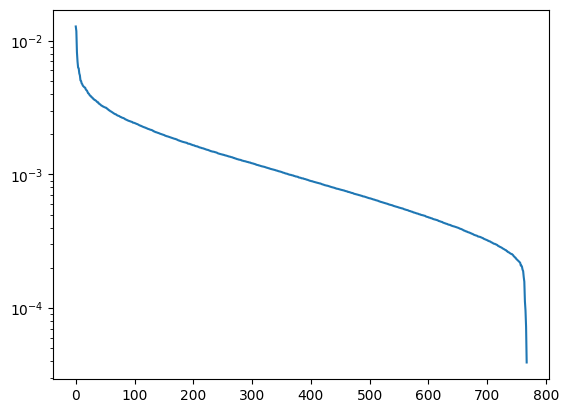

In [82]:
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')